In [1]:
%matplotlib notebook
import psutil
import sys

print(sys.version)
psutil.virtual_memory()

2.7.15 |Anaconda, Inc.| (default, Oct 10 2018, 21:32:13) 
[GCC 7.3.0]


svmem(total=270853824512, available=252222693376, percent=6.9, used=17893621760, free=213893320704, active=16727429120, inactive=33308360704, buffers=775385088, cached=38291496960, shared=253952, slab=4152229888)

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [9]:
n_realization = 31 # 31
list_da = []
for i in range(1,n_realization+1):
    path = '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r'+str(i)+'i1p1f1/LImon/snc/gr/latest/snc_LImon_IPSL-CM6A-LR_historical_r'+str(i)+'i1p1f1_gr_185001-201412.nc'
    list_da.append(xr.open_dataset(path).snc.sel(time=slice('2005','2014'), lat=slice(20, 90)))
    
snc = xr.concat(list_da, pd.Index(['r'+str(i)+'i1p1f1' for i in range(1,n_realization+1)], name='realization'))
del list_da
psutil.virtual_memory()

svmem(total=270853820416, available=67712151552, percent=75.0, used=202472120320, free=49414918144, active=75276689408, inactive=26196525056, buffers=345665536, cached=18621116416, shared=212992, slab=117042511872)

In [10]:
snc

<xarray.DataArray 'snc' (realization: 31, time: 120, lat: 56, lon: 144)>
array([[[[ 0., ...,  0.],
         ...,
         [nan, ..., nan]],

        ...,

        [[ 0., ...,  0.],
         ...,
         [nan, ..., nan]]],


       ...,


       [[[ 0., ...,  0.],
         ...,
         [nan, ..., nan]],

        ...,

        [[ 0., ...,  0.],
         ...,
         [nan, ..., nan]]]], dtype=float32)
Coordinates:
  * lat          (lat) float32 20.28169 21.549295 22.816902 24.084507 ...
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time         (time) datetime64[ns] 2005-01-16T12:00:00 2005-02-15 ...
  * realization  (realization) object 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1' ...
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    

In [11]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [12]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [13]:
snc.time.to_index()

DatetimeIndex(['2005-01-16 12:00:00', '2005-02-15 00:00:00',
               '2005-03-16 12:00:00', '2005-04-16 00:00:00',
               '2005-05-16 12:00:00', '2005-06-16 00:00:00',
               '2005-07-16 12:00:00', '2005-08-16 12:00:00',
               '2005-09-16 00:00:00', '2005-10-16 12:00:00',
               ...
               '2014-03-16 12:00:00', '2014-04-16 00:00:00',
               '2014-05-16 12:00:00', '2014-06-16 00:00:00',
               '2014-07-16 12:00:00', '2014-08-16 12:00:00',
               '2014-09-16 00:00:00', '2014-10-16 12:00:00',
               '2014-11-16 00:00:00', '2014-12-16 12:00:00'],
              dtype='datetime64[ns]', name=u'time', length=120, freq=None)

In [14]:
# Make a DataArray with the number of days in each month, size = len(time)
month_length = xr.DataArray(get_dpm(snc.time.to_index(), calendar='gregorian'),
                            coords=[snc.time], name='month_length')

# Attention erreur : https://github.com/pydata/xarray/pull/3464/commits/8d50626dfbf123340ad26508180988e5e7ac20b4

In [18]:
month_length.sel(time='2008')

<xarray.DataArray 'month_length' (time: 12)>
array([32, 29, 32, 31, 32, 31, 32, 32, 31, 32, 31, 32])
Coordinates:
  * time     (time) datetime64[ns] 2008-01-16T12:00:00 2008-02-15T12:00:00 ...

In [172]:
# Calculate the weights by grouping by 'time.season'.
# Conversion to float type ('astype(float)') only necessary for Python 2.x
weights = month_length.groupby('time.season') / month_length.astype(float).groupby('time.season').sum()

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (snc * weights).groupby('time.season').sum(dim='time', skipna=False)

In [173]:
ens_avg_snow_MAM = ds_weighted.sel(season='MAM').mean('realization')

In [174]:
cyclic_data, cyclic_lons = add_cyclic_point(ens_avg_snow_MAM.values, coord=ens_avg_snow_MAM.lon)

In [175]:
ens_avg_snow_MAM_cyclic = xr.DataArray(
    cyclic_data,
    coords={'lat': ens_avg_snow_MAM.lat, 'lon': cyclic_lons, 'season': ens_avg_snow_MAM.season},
    dims=['lat', 'lon']
)

In [176]:
ens_avg_snow_MAM_cyclic.name = 'snc'
ens_avg_snow_MAM_cyclic.attrs['long_name'] = 'Snow cover'
ens_avg_snow_MAM_cyclic.attrs['units'] = '%'

<IPython.core.display.Javascript object>


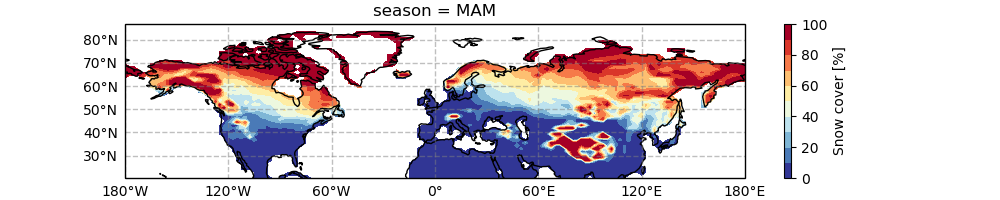

In [177]:
plt.figure(figsize=(10,2))
ax = plt.axes(projection=ccrs.PlateCarree())

ens_avg_snow_MAM_cyclic.plot.contourf(
    ax=ax, 
    transform=ccrs.PlateCarree(),
    levels=range(0,110,10),
    cmap='RdYlBu_r'
#     cbar_kwargs={'orientation':'horizontal'}
)

ax.coastlines()
ax.set_aspect('auto')
# ax.add_feature(cartopy.feature.OCEAN, zorder=10, color='gray')

# https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER